In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Limitting the memory growth of GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimetnal.set_memory_growth(gpu, True)

In [3]:
import cv2 as cv
import imghdr

C:\Users\pokar\AppData\Local\Temp\ipykernel_18812\1505331735.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


## Filtering Data

In [4]:
data_dir = 'data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [5]:
# To enter inside the happy folder and get every image
# os.listdir(os.path.join(data_dir, 'happy'))

In [6]:
# To filter the images:
# 1. First delete all the imgages which of are of size <10KB
# 2. Delete all svg files

In [7]:
# Removing dodgy images:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv.imread(image_path) # Checks if we can load the image into opencv
            tip = imghdr.what(image_path)# Gets the extensions of image, and below we remove all who are not in image_exts
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image{}'.format(image_path))

## Loading Data

In [8]:
data = tf.keras.utils.image_dataset_from_directory('data') # Building our data pipeline
data_iterator = data.as_numpy_iterator() # Allowing to loop through the data pipeline

Found 205 files belonging to 2 classes.


In [9]:
# Get another batch from iterator
batch = data_iterator.next() # Accessing the data pipeline
# batch[0] gives all images as arrys and batch[1] gives the labels corresponding to every image i.e. 0 for happy and 1 for sad

In [10]:
batch[0].shape # default batch size is 32 i.e. every batch will contain 32 images
# This means we have got 32 images of 256x256 across 3 channels

(32, 256, 256, 3)

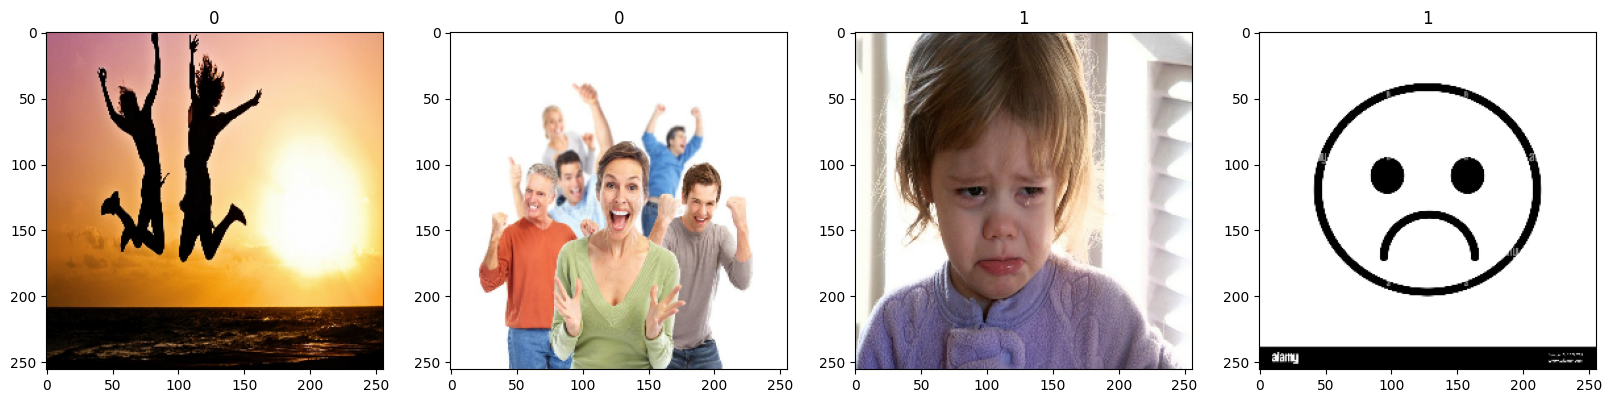

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Preprocessing data

## Scaling data

In [12]:
data = data.map(lambda x, y: (x/255, y)) # Transforms data while it is being loaded into pipeline (x is images(batch[0]), and y are labels batch[1])

In [13]:
scaled_iterator = data.as_numpy_iterator() # Gives iterator for looping through data

In [14]:
batch = scaled_iterator.next() # Gives batch of scaled indexed data

## Spliting data

In [15]:
len(data) # i.e. there are 7 batches with each batch having 32 images except for the last one

7

In [16]:
train_size = int(len(data) * 0.7) # Used to train the model
val_size = int(len(data)*0.2) + 1 # Used to evaluate the model while we are training it
test_size = int(len(data) * 0.1) + 1 # Used for testing
print(train_size, val_size, test_size) # Thus 4 batches for training, 2 for evaluating and 1 for testing

4 2 1


In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# Deep Model

## Building the model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [24]:
model = Sequential()

In [26]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten()) 

model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [28]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 16)        4